In [56]:
%matplotlib inline

In [142]:
from pylab import *
import pylab
import matplotlib as mpl
import numpy
import lnm
from graph import Graph
import ipywidgets as widgets
from IPython.display import display, HTML
mpl.rcParams['savefig.dpi'] = 150
OPTIONS = {'FSM': 'results_fsm.txt',
           'KCFA (6.2.1)': 'results_kcfa_head.txt',
           'Snake (HEAD)': 'results_snake.txt',
           'Snake (6.2.1)': 'results_snake_03-11-15.txt',
           'Tetris': 'results_tetris.txt',
           'Sieve': 'results_sieve.txt',
           'Suffix Tree (6.2.1)': 'results_suffixtree_03-11-15.txt',
           'Synth (HEAD)':'results_synth.txt',
           'Synth (6.2.1)': 'results_synth_03-11-15.txt'}
s = widgets.Dropdown(options=OPTIONS)
all_data_files = ['results_fsm.txt',
                  'results_snake.txt',
                  'results_tetris.txt',
                  'results_sieve.txt',
                  'result_kcfa_21-11-15.txt',
                  'results_suffixtree_03-11-15.txt',
                  'results_synth.txt']

In [206]:
display(s)

In [207]:
HTML("<h1>Filename: '" + s.value + "'</h1>")

# Select Benchmark:

In [208]:
graph = lnm.read_data(s.value)
variations, data = graph.ungraph()
hidden_untyped = data[0,2]
pycket_untyped = data[0,1]
racket_untyped = data[0,0]
hidden = data[:,2]
pycket = data[:,1]
racket = data[:,0]

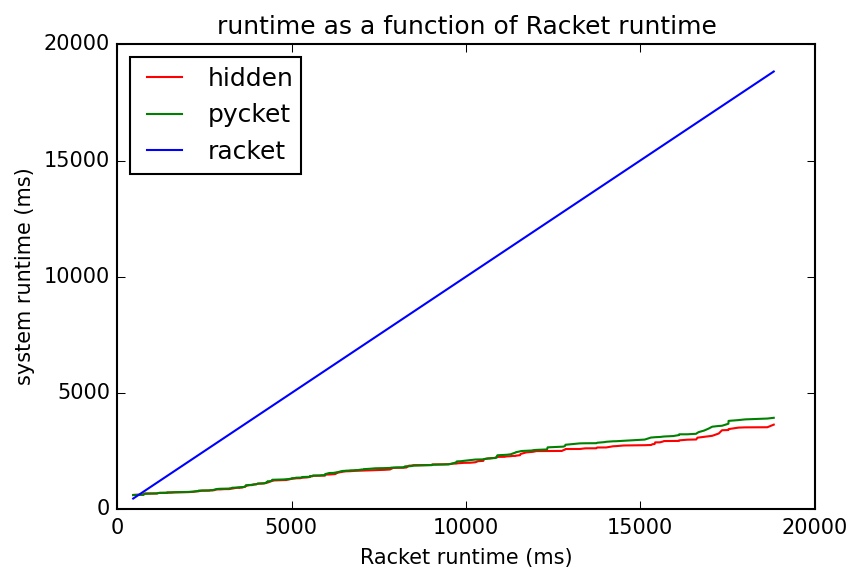

In [209]:
# Runtime of Pycket as a function of Racket
ordered_data = np.copy(data)
ordered_data.sort(axis=0)
ohidden = ordered_data[:,2]
opycket = ordered_data[:,1]
oracket = ordered_data[:,0]
pylab.plot(oracket, ohidden, 'r', label='hidden')
pylab.plot(oracket, opycket, 'g', label='pycket')
pylab.plot(oracket, oracket, 'b', label='racket')
pylab.title('runtime as a function of Racket runtime')
pylab.xlabel('Racket runtime (ms)')
pylab.ylabel('system runtime (ms)')
pylab.legend(loc='best')

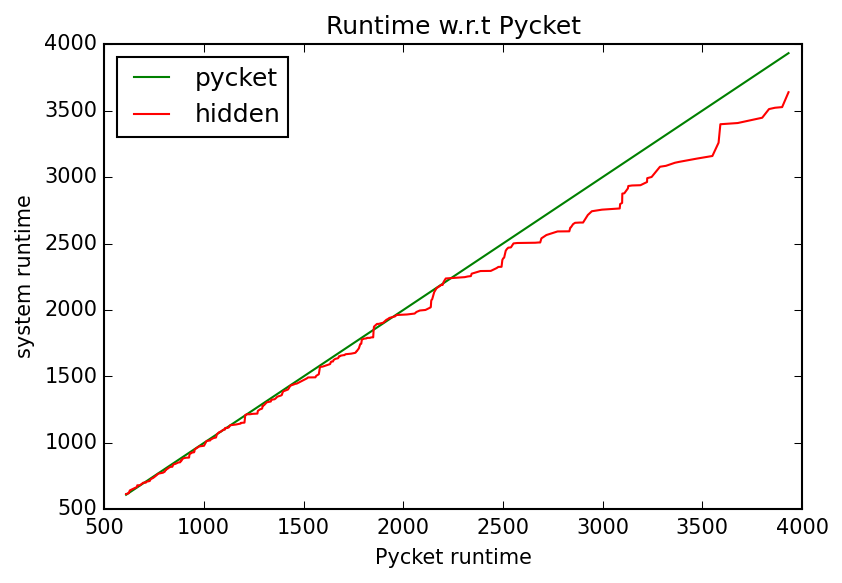

In [210]:
pylab.plot(opycket, opycket, 'g', label='pycket')
pylab.plot(opycket, ohidden, 'r', label='hidden')
pylab.title('Runtime w.r.t Pycket')
pylab.xlabel('Pycket runtime')
pylab.ylabel('system runtime')
pylab.legend(loc='best')

In [211]:
from scipy.stats import cumfreq
from pandas      import DataFrame
from ipy_table   import *

hidden_slowdown = hidden / float(hidden_untyped)
pycket_slowdown = pycket / float(pycket_untyped)
racket_slowdown = racket / float(racket_untyped)

def make_slowdown_data(fname):
    data = np.genfromtxt(fname, usecols=(1,2,3))
    hidden_untyped = float(data[0,2])
    pycket_untyped = float(data[0,1])
    racket_untyped = float(data[0,0])
    hidden = data[:,2]
    pycket = data[:,1]
    racket = data[:,0]
    weights = np.ones(len(hidden)) / float(len(hidden))
    return racket / racket_untyped, pycket / pycket_untyped, hidden / hidden_untyped, weights

def compute_deliverable(data):
    th = sum(data < 3)
    oh = sum(numpy.logical_and(data >= 3, data < 10))
    return [max(data), numpy.mean(data), np.median(data), "%d (%0.2f%%)" % (th, th / float(len(data)) * 100), "%d (%0.2f%%)" % (oh, oh / float(len(data)) * 100)]

def make_deliverable_table(**kwargs):
    lst = [["", "Max overhead", "Mean overhead", "Median overhead", "300-deliverable", "300/1000-usable"]]
    for name, data in kwargs.iteritems():
        lst.append([name] + compute_deliverable(data))
    tbl = make_table(map(list, zip(*lst)))
    apply_theme('basic_both')
    return tbl

def slowdown_cdf(*args, **kwargs):
    weights = kwargs.get('weights', None)
    entries = 0
    for data, color, label in args:
        if weights is not None:
            counts, bin_edges = numpy.histogram(data, weights=weights, bins=len(data))
            entries = np.sum(weights)
        else:
            counts, bin_edges = numpy.histogram(data, bins=len(data))
            entries = len(data)
        cdf = numpy.cumsum(counts)
        pylab.plot(bin_edges[:-1], cdf, color=color, label=label)
    pylab.axvline(3, color='y')
    pylab.axvline(10, color='k')
    pylab.axhline(len(data) * 0.6, color='c', ls='--')
    pylab.xlabel('slowdown factor')
    pylab.xlim((1,20))
    pylab.ylim((0,entries))
    pylab.ylabel('number below')
    pylab.legend(loc='best')
    
def compute_lnm_deliverable(slowdown_graph, L):
    graph = lnm.compute_lnm_times(slowdown_graph, L)
    data = graph.ungraph()[1]
    rs = data[:,0]
    ps = data[:,1]
    hs = data[:,2]
    return rs, ps, hs, make_deliverable_table(racket=rs, pycket=ps,hidden=hs)
    
rs, ps, hs, weights = zip(*[make_slowdown_data(fname) for fname in all_data_files])
rs = reduce(np.append, rs)
ps = reduce(np.append, ps)
hs = reduce(np.append, hs)
weights = reduce(np.append, weights)

# All Data

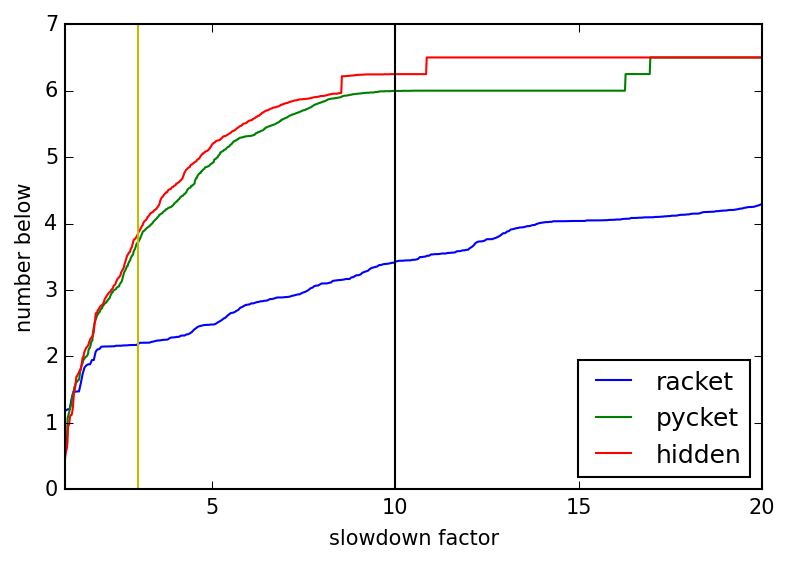

In [212]:
slowdown_cdf((rs, 'b', 'racket'),
             (ps, 'g', 'pycket'),
             (hs, 'r', 'hidden'),
             weights=weights)

# Slowdown Summary Stats

In [213]:
DataFrame({'racket':racket, 'pycket':pycket, 'hidden':hidden}).describe()

,hidden,pycket,racket
count,256.000000,256.000000,256.000000
mean,1686.222656,1752.125000,7596.062500
std,742.652343,819.954686,4586.031387
min,615.000000,609.000000,460.000000
25%,1071.000000,1069.250000,3970.000000
50%,1597.500000,1634.000000,6414.000000
75%,2240.250000,2243.500000,10887.000000
max,3639.000000,3933.000000,18828.000000


# Deliverability Stats

## L = 0

In [214]:
slowdown_graph = lnm.fromkeyvals(variations, racket_slowdown, pycket_slowdown, hidden_slowdown)
racket_slowdown0, pycket_slowdown0, hidden_slowdown0, tbl = compute_lnm_deliverable(slowdown_graph, 0)
tbl

,racket,hidden,pycket
Max overhead,31.8041,5.8599,6.3130
Mean overhead,12.8312,2.7153,2.8124
Median overhead,10.8345,2.5725,2.6228
300-deliverable,16 (6.25%),164 (64.06%),167 (65.23%)
300/1000-usable,99 (38.67%),92 (35.94%),89 (34.77%)


## L = 1

In [215]:
racket_slowdown1, pycket_slowdown1, hidden_slowdown1, tbl = compute_lnm_deliverable(slowdown_graph, 1)
tbl

,racket,hidden,pycket
Max overhead,12.6959,3.4364,2.9679
Mean overhead,5.5139,1.5638,1.5783
Median overhead,5.4932,1.4235,1.4414
300-deliverable,68 (26.56%),255 (99.61%),256 (100.00%)
300/1000-usable,164 (64.06%),1 (0.39%),0 (0.00%)


## L = 2

In [216]:
racket_slowdown2, pycket_slowdown2, hidden_slowdown2, tbl = compute_lnm_deliverable(slowdown_graph, 2)
tbl

,racket,hidden,pycket
Max overhead,9.0946,1.9469,1.9342
Mean overhead,2.9838,1.1870,1.1870
Median overhead,2.0743,1.1272,1.1156
300-deliverable,156 (60.94%),256 (100.00%),256 (100.00%)
300/1000-usable,100 (39.06%),0 (0.00%),0 (0.00%)


# Slowdown distribution

## L = 0

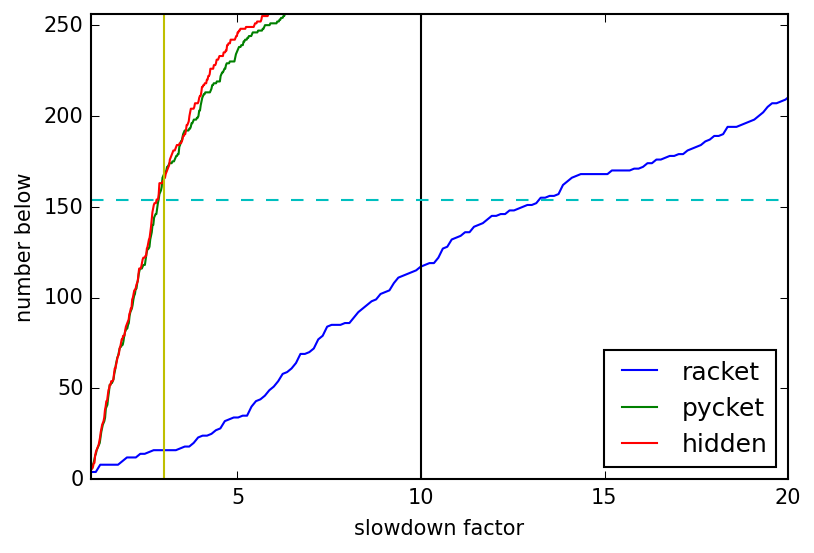

In [217]:
slowdown_cdf((racket_slowdown0, 'b', 'racket'),
             (pycket_slowdown0, 'g', 'pycket'),
             (hidden_slowdown0, 'r', 'hidden'))

## L = 1

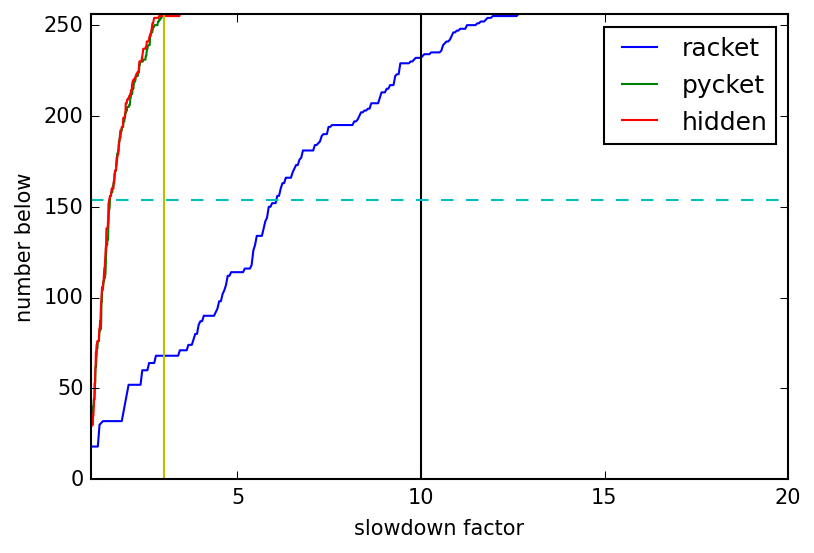

In [218]:
slowdown_cdf((racket_slowdown1, 'b', 'racket'),
             (pycket_slowdown1, 'g', 'pycket'),
             (hidden_slowdown1, 'r', 'hidden'))

## L = 2

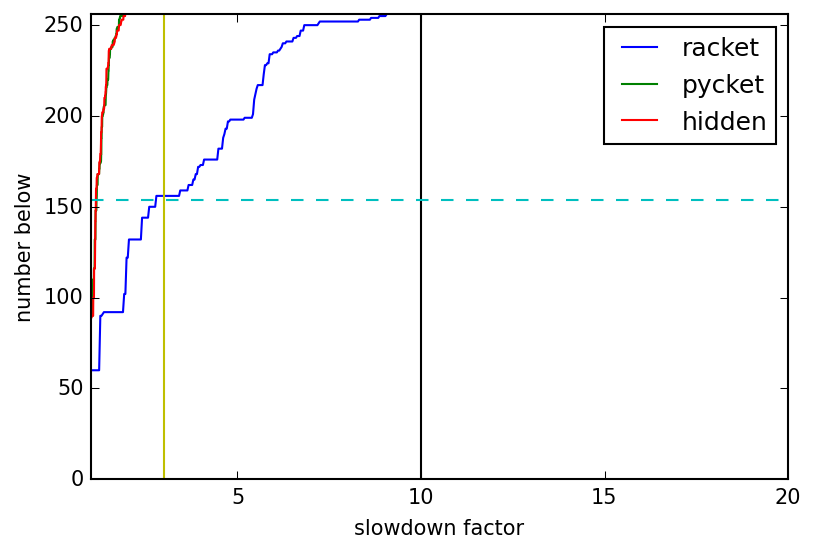

In [219]:
slowdown_cdf((racket_slowdown2, 'b', 'racket'),
             (pycket_slowdown2, 'g', 'pycket'),
             (hidden_slowdown2, 'r', 'hidden'))